# Pairwise alignments and edit distance

A pairwise alignment of two sequences

```python
x = 'ACCATGACC'
y = 'AGATGAGC'
```

is a sequence of pairs (columns) containing the letters from the sequences or the special symbol `'-'`, representing "gaps". The pair `('-','-')` is not allowed. We do not typically represent the columns directly as pairs, but as one sequence over another, e.g. we would write

```
ACCATGACC
AG-ATGAGC
```

to represent the alignment


In [1]:
alignment = [('A','A'), ('C','G'), ('C','-'), ('A','A'), ('T','T'), ('G','G'), ('C','G'), ('C','C')]

We can extract the textual representation of an alignment quite easily:

In [3]:
def print_alignment(algn):
    first = ''.join(first for first,second in algn)
    second = ''.join(second for first,second in algn)
    print("{}\n{}".format(first, second))
    
print_alignment(alignment)

ACCATGCC
AG-ATGGC


If you stare at this function long enough, you will se that we use to list comprehensions (strictkly speaking generators, but the difference is academic): we get the first elements from the pairs and the second elements from the pairs. We then use the invocation `''.join(...)` to translate those lists of strings into single strings. The `join` method is part of what strings can do. Finally, we print the result.

We can associate a so-called *edit distance* between the two sequences represented in the alignment. This distance measure counts how many operations were made to change the first sequence into the other (or vice versa). The possible operations are substituting one symbol into another, adding a gap in the first sequence, or adding a gap in the second sequence.

Given an alignment represented as these pairs, we can count the operations by simply counting the number of pairs where the two symbols do not match. We can implement that idea in very many different ways. Which you would prefer is a matter of taste.

In [4]:
def edit_distance_loop(algn):
    dist = 0
    for first,second in algn:
        if first != second:
            dist += 1
    return dist

def edit_distance_sum(algn):
    return sum(1 for first,second in algn if first != second)

def edit_distance_len(algn):
    return len([1 for first,second in algn if first != second])

print("loop: ", edit_distance_loop(alignment))
print("sum:  ", edit_distance_sum(alignment))
print("len:  ", edit_distance_len(alignment))

loop:  3
sum:   3
len:   3


## Constructing alignments

We are often interested in aligning two sequences, i.e. building an alignment from them, since aligned sequences are informative about homology. Given two sequences, the *optimal* alignment is the alignment with the smallest distance, in the context of this exercise, the edit distance. Strictly speaking, we will be looking for *an* optimal alignment--there might be more than one with the same optimal score. We want to find one of these.

One approach to finding an optimal alignment is to enumerate all possible alignments, compute their score, and pick an optimal one.

So how do we compute all alignments of two sequences? We can attack this problem recursively.

1. If one of the two strings is empty, we need to match the characters in the other with gap characters.
2. Otherwise, we need to 
   1. prepend the pair of the first characters in the two strings to all alignments of the remaining of the strings, 
   2. prepend the pair of the first character of the first string with a gap to all alignments of the first string minus its first character against the second string
   3. prepend the pair of a gap with the first character of the second string to all alignments of the first string against the second string minus its first character 

In [5]:
def generate_all_alignments(first, second):
    if first == "":
        return [[('-',x) for x in second]]
    if second == "":
        return [[(x,'-') for x in first]]

    match_alignments = [[(first[0],second[0])] + alignment 
                        for alignment in generate_all_alignments(first[1:], second[1:])]
    
    insertion_alignments = [[(first[0],'-')] + alignment 
                            for alignment in generate_all_alignments(first[1:], second)]
    
    deletion_alignments = [[('-',second[0])] + alignment 
                           for alignment in generate_all_alignments(first, second[1:])]
    
    return match_alignments + insertion_alignments + deletion_alignments

The basic cases handle when one of the sequences is empty. Notice that we need to have two square brackets around the result we return. We want the function to return a list of lists, so even though we are generating a list of singleton pairs, we need to wrap those pairs in lists, thus the square brackets.

This function is somewhat inefficient. In the recursive calls, we slice off the first character in one or both of the sequences, which means we need to copy the sequences. A version that use indices into the sequences instead, in the recursive calls, would be more efficient. We also copy lists every time we concatenate them, which we do all the time in this function. Constructing the alignments from the other direction, and using the `append` method on lists, would also make the function more efficient. We won't worry about the efficiency, however, since generating all possible alignments is not going to be a scalable approach in any case. We will see that shortly. If you want to experiment with the function, though, you can try to make it more efficient.

For now, let us just see the alignment generation in action:

In [6]:
alignments = generate_all_alignments('ACGGC','CGGGA')

scored_alignments = [(algn,edit_distance_sum(algn)) for algn in alignments]
optimal_score = min(score for algn,score in scored_alignments)
optimal_alignments = [algn for algn,score in scored_alignments if score == optimal_score]

print("There are {} alignments.".format(len(alignments)))
print("There are {} optimal alignments.\n".format(len(optimal_alignments)))
for alignment in optimal_alignments:
    print_alignment(alignment)
    print("with score {}\n".format(edit_distance_sum(alignment)))

There are 1683 alignments.
There are 5 optimal alignments.

ACGGC
CGGGA
with score 3

ACGGC-
-CGGGA
with score 3

ACGG-C
-CGGGA
with score 3

ACG-GC
-CGGGA
with score 3

AC-GGC
-CGGGA
with score 3



To see that this is not a viable solution to finding an optimal alignment, we can explore how many alignments there are for sequences of length $n$ and $m$. The alignment scores--the edit distance between two sequences--depends on the actual sequences, but the number of possible alignments do not. We can compute the number of alignments, $N(n,m)$, with a recursion very simpliar to the one we used to generate alignments--not surprisingly.

$$N(n,m) = \begin{cases}
1 & n = 0 \lor m = 0 \\
N(n-1,m-1) + N(n-1,m) + N(n,m-1) & \mathrm{otherwise}
\end{cases}
$$

In [7]:
def N(n,m):
    if n == 0 or m == 0:
        return 1
    else:
        return N(n-1,m-1) + N(n-1,m) + N(n,m-1)

In [8]:
N(len("ACGGC"),len("CGGGA"))

1683

The number of alignments must grow as $\Omega(3^n)$, considering that for each non-base case we have at least three alignment-lists, but some experiments show that it is substantially worse than this rough lower bound:

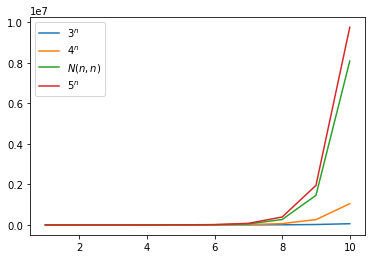

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

ns = list(range(1,11))

fig, ax = plt.subplots()
ax.plot(ns, [3**n for n in ns], label = "$3^n$")
ax.plot(ns, [4**n for n in ns], label = "$4^n$")
ax.plot(ns, [N(n,n) for n in ns], label = "$N(n,n)$")
ax.plot(ns, [5**n for n in ns], label = "$5^n$")
ax.legend(loc='upper left')

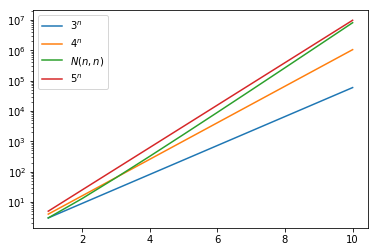

In [10]:
fig, ax = plt.subplots()
ax.set_yscale("log", nonposy='clip')
ax.plot(ns, [3**n for n in ns], label = "$3^n$")
ax.plot(ns, [4**n for n in ns], label = "$4^n$")
ax.plot(ns, [N(n,n) for n in ns], label = "$N(n,n)$")
ax.plot(ns, [5**n for n in ns], label = "$5^n$")
ax.legend(loc='upper left')

## Dynamic programming

If you try to extend the graph above much higher than $n=10$ you will soon loose patience waiting for the $N(n,n)$ computations to finish. This is not surprising, considering that to compute $N(n,n)$ you actually have to run through $N(n,n)$ recursions. Most of the computations, however, are of the same pairs of numbers, $N(m,k)$. This is a problem that will be much more efficient to solve using *dynamic programming*.

With dynamic programming, we build a table to store the value of computations in, so we do not need to computing them more than once. There are two approaches to dynamic programming. We can use a recursion, as above, but check if a value is already known before we call recursively. This approach is also known as *memorisation*. Alternatively, we can make sure that all the values we need are known when we need them by turning the computation on its head and build values up from the base cases up to the value we are interested in.

We can try implementing both approaches. For memorisation, we need a table and a way to indicate that we haven't computed a value yet. Since we are counting the number of alignments, and this cannot be a negative number, we will use `-1` to indicate this. We can use the [`numpy.empty`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.empty.html) function to create an empty table. It will not initialize values (for that, you might want to look at the `zeros` function, for example), but that is fine. We will put missing values in all entries anyway.

Now, normally we would need to write loops to run through all cells in a table and assign the mising value to them, but tables from numpy have a special syntax for this (see the code below that says `table[:,:] = MISSING`). We won't be exploring numpy as more than tables in this class, though, so just think of this as two nested loops through the cells of the table.

I have split the implementation into three functions. One for making the table--we will need to look up values at cell $(n,m)$ so we need to allocate rows and columns one larger, $(n+1,m+1)$--a second function for the recursive calls that use the table so it only computes values that are missing but otherwise just return the memorized values--and a final function that allocates the table and then starts the recursion.

In [11]:
import numpy as np
MISSING = -1

def make_missing_table(n, m):
    table = np.empty(shape = (n+1,m+1), dtype=int)
    table[:,:] = MISSING
    return table

def memorize_helper(table, n, m):
    if table[n,m] == MISSING:
        if n == 0 or m == 0:
            table[n,m] = 1
        else:
            table[n,m] = memorize_helper(table, n-1,m-1) + \
                         memorize_helper(table, n-1,m) + \
                         memorize_helper(table, n,m-1)
    return table[n,m]

def memorize_N(n,m):
    table = make_missing_table(n, m)
    return memorize_helper(table, n, m)

To test the new implementation, we can compare results with the previous, simpler, implementation:

In [12]:
for n in range(1,5):
    for m in range(1,5):
        print("N({},{}) == {}, memorize_N({},{}) == {}".format(n,m,N(n,m),n,m,memorize_N(n,m)))

N(1,1) == 3, memorize_N(1,1) == 3
N(1,2) == 5, memorize_N(1,2) == 5
N(1,3) == 7, memorize_N(1,3) == 7
N(1,4) == 9, memorize_N(1,4) == 9
N(2,1) == 5, memorize_N(2,1) == 5
N(2,2) == 13, memorize_N(2,2) == 13
N(2,3) == 25, memorize_N(2,3) == 25
N(2,4) == 41, memorize_N(2,4) == 41
N(3,1) == 7, memorize_N(3,1) == 7
N(3,2) == 25, memorize_N(3,2) == 25
N(3,3) == 63, memorize_N(3,3) == 63
N(3,4) == 129, memorize_N(3,4) == 129
N(4,1) == 9, memorize_N(4,1) == 9
N(4,2) == 41, memorize_N(4,2) == 41
N(4,3) == 129, memorize_N(4,3) == 129
N(4,4) == 321, memorize_N(4,4) == 321


Memorisation is mostly used when we do not know, *a priori*, which recursive calls we will need, or in which order we will need them. Checking for missing-ness and implementing the computations as recursions add some overhead, however, compared to the more traditional dynamic programming approach where we compute all values we will need before we need them.

In these computations we know that we will need all values $N(i,j)$ for $0 \leq i \leq n, 0 \leq j \leq m$, so we can compute them in increasing over of $i$ and $j$. Doing so, we will always have what we need when we need it. We fill out the first row and column of the table using the base case rules, and after that simply iterate through the rest of the table cells:

In [13]:
def make_empty_table(n, m):
    return np.empty(shape = (n+1,m+1), dtype=int)

def dynprog_N(n,m):
    table = make_empty_table(n,m)
    for i in range(n+1):
        table[i,0] = 1
    for j in range(m+1):
        table[0,j] = 1
    for i in range(1,n+1):
        for j in range(1,m+1):
            table[i,j] = table[i-1,j-1] + table[i-1,j] + table[i,j-1]
    return table[n,m]

In [14]:
for n in range(1,5):
    for m in range(1,5):
        print("N({},{}) == {}, dynprog_N({},{}) == {}".format(n,m,N(n,m),n,m,dynprog_N(n,m)))

N(1,1) == 3, dynprog_N(1,1) == 3
N(1,2) == 5, dynprog_N(1,2) == 5
N(1,3) == 7, dynprog_N(1,3) == 7
N(1,4) == 9, dynprog_N(1,4) == 9
N(2,1) == 5, dynprog_N(2,1) == 5
N(2,2) == 13, dynprog_N(2,2) == 13
N(2,3) == 25, dynprog_N(2,3) == 25
N(2,4) == 41, dynprog_N(2,4) == 41
N(3,1) == 7, dynprog_N(3,1) == 7
N(3,2) == 25, dynprog_N(3,2) == 25
N(3,3) == 63, dynprog_N(3,3) == 63
N(3,4) == 129, dynprog_N(3,4) == 129
N(4,1) == 9, dynprog_N(4,1) == 9
N(4,2) == 41, dynprog_N(4,2) == 41
N(4,3) == 129, dynprog_N(4,3) == 129
N(4,4) == 321, dynprog_N(4,4) == 321


The three functions for computing the number of alignments compute the same values, but with dramatically different running times and with the dynamic programming approach being the fastest.

In [15]:
%timeit N(4,7)
%timeit memorize_N(4,7)
%timeit dynprog_N(4,7)

580 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
57.1 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
24 µs ± 600 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


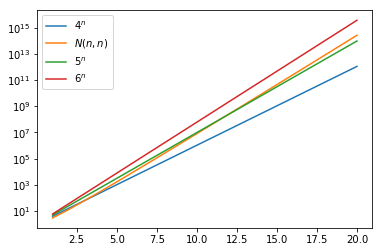

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

ns = list(range(1,21))

fig, ax = plt.subplots()
ax.set_yscale("log", nonposy='clip')
ax.plot(ns, [4**n for n in ns], label = "$4^n$")
ax.plot(ns, [dynprog_N(n,n) for n in ns], label = "$N(n,n)$")
ax.plot(ns, [5**n for n in ns], label = "$5^n$")
ax.plot(ns, [6**n for n in ns], label = "$6^n$")
ax.legend(loc='upper left')

With dynamic programming, we have made the $N(n,m)$ computation much faster. We cannot move much beyond $n=m=20$, though, because we will run into overflow; there is a limit to how large numbers we can store in numpy arrays. (Python can represent arbitrarily large integers but numpy cannot).

## Computing the optimal edit distance

We have seen how to compute the edit distance for a given alignment, but what about computing the minimal edit distance between two sequences? That is, computing the minimal distance over all possible alignments?

Considering how many alignments there are, it is a no-go to enumerate them all to compute this distance. We can, however, be inspired by the recursion for computing the number of alignments and use something similar to compute the edit distance, $D(x,y)$.

The basic cases are similar to the counting recursion, $N(n,m)$, except that we are not counting that there is a single alignment possible, but rather that the cost of that alignment is the length of the non-empty string

$$D(x,"") = |x|$$
$$D("",y) = |y|$$

For the recursive case, we need to consider the same three recursive calls as for the $N$ function, but instead of adding numbers together we want to take the minimum since we are looking for the minimal edit cost in an alignment. The cost of the *match* case depends on whether the two characters we try to match are equal or different, if equal the extra cost is zero while it is one otherwise, while the gap cases always increase the cost by one.

$$D(x,y) = \min\left\{\mathbf{1}_{x_1\neq y_1} + D(x_{2\ldots n}, y_{2\ldots m}),
                      1 + D(x_{2\ldots n}, y),
                      1 + D(x, y_{2\ldots m})
               \right\}$$

Here, I've used the notation $\mathbf{1}_{x_1\neq y_1}$ to denote a function that is 1 if the two characters are equal and zero otherwise. The notation is similar to indicator variables in statistics.

As written here, the recursion starts from the left and moves from zero indices up to the length of $x$ and $y$, respectively. We can modify it to run from the end of the strings, indices $n$ and $m$, to make it look even more like the $N(n,m)$ function. If we do this, we get

$$D(n,m) = \begin{cases}
n & m = 0 \\
m & n = 0 \\
\min\left\{\mathbf{1}_{x_{n-1}\neq y_{m-1}} + D(n-1,m-1), 1 + D(n-1,m), 1 + D(n,m)\right\}
\end{cases}$$

In the recursive case, we need to subtract one from the indices when comparing the last elements in the strings. This is simply a consequences of indexing from zero; the last elements are the lengths minus one.

In [17]:
def D_helper(x, y, n, m):
    if n == 0:
        return m
    if m == 0:
        return n
    return min( (x[n-1] != y[m-1]) + D_helper(x, y, n-1, m-1),
                1 + D_helper(x, y, n-1, m),
                1 + D_helper(x, y, n, m-1))
    
def D(x, y):
    return D_helper(x, y, len(x), len(y))               

The dynamic programming variant is also similar to the version we wrote for the counting function:

In [26]:
def dynprog_D(x, y):
    n, m = len(x), len(y)
    table = make_empty_table(n, m)
    
    for i in range(n+1):
        table[i,0] = i
    for j in range(m+1):
        table[0,j] = j
        
    for i in range(1,n+1):
        for j in range(1,m+1):
            table[i,j] = min( (x[i-1] != y[j-1]) + table[i-1, j-1],
                              1 + table[i-1, j],
                              1 + table[i,j-1] )

    return table[n,m]

We can see how the dynamic programming approach works with a few figues.

At the beginning of the algorithm, we fill out the first row and the first column.

![Initial table](figures/dynprog-empty-alignment.png)

The upper left corner represent the empty sequence aligned to the empty sequence. The first row, the empty sequence aligned to prefixes of the second string, and the first column captures prefixes of the first sequence aligned to the empty string.

![](figures/dynprog-edge-cases.png)

The first step in the nested loops will fill out the first non-edge case, which is either a match case, of "A" against "A", or an insertion or a deletion. Of these choices, the lowest cost is the match.

![](figures/dynprog-first-non-edge-case.png)

The rest of the table is simply filled out in the same way.

![](figures/dynprog-complete.png)

To test these functions, we can compare their results with what we would get by exchausively computing all alignments and then picking the best scoring one.

In [19]:
def exchaustive_D(x, y):
    alignments = generate_all_alignments(x, y)
    return min(edit_distance_sum(a) for a in alignments)

In [20]:
sequences = ['AACAC', 'CAAAG', 'ACA', 'A', 'GGGGG', 'AAAAAAAA']
for i in range(len(sequences)):
    for j in range(i):
        x = sequences[i]
        y = sequences[j]
        print("{} vs {}, {}, {}, {}".format(x, y, D(x,y), dynprog_D(x,y), exchaustive_D(x,y)))


CAAAG vs AACAC, 3, 3, 3
ACA vs AACAC, 2, 2, 2
ACA vs CAAAG, 3, 3, 3
A vs AACAC, 4, 4, 4
A vs CAAAG, 4, 4, 4
A vs ACA, 2, 2, 2
GGGGG vs AACAC, 5, 5, 5
GGGGG vs CAAAG, 4, 4, 4
GGGGG vs ACA, 5, 5, 5
GGGGG vs A, 5, 5, 5
AAAAAAAA vs AACAC, 5, 5, 5
AAAAAAAA vs CAAAG, 5, 5, 5
AAAAAAAA vs ACA, 6, 6, 6
AAAAAAAA vs A, 7, 7, 7
AAAAAAAA vs GGGGG, 8, 8, 8


The three functions compute the same value, but, as was the case for $N(n,m)$, the dynamic programming algorithm is much more efficient.

In [21]:
x, y = 'GGGGG', 'AAAAAAAA'
%timeit exchaustive_D(x, y)
%timeit D(x, y)
%timeit dynprog_D(x, y)

77.9 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.85 ms ± 11.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
105 µs ± 1.12 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Backtracking



Of course, knowing what the score for an optimal alignment is doesn't actually tell us what that *alignment* is. We can, however, work that out from the table we fill out in the dynamic programming function.

If we are at the cell $(i,j)$ for $i,j>0$, the cost at this cell must have been calculated from one of the three cells $(i-1,j-1)$, $(i-1,j)$ or $(i,j-1)$. We can figure out which one. When we have figured that out, we can in principle solve the recursive problem of finding the optimal alignment for that cell and then just append the alignment pair that match the transition from that cell to the current.

For that recursive function to work, we just need to handle the base cases. Those are the cases where either $i$ or $j$ are empty. For those, we just need to construct pairs that match the characters in the non-empty string.

We can put all this together in a function that constructs a pairwise alignment. We split it into two helper functions, one for filling the dynamic programming table and one for backtracking. The full alignment code looks like this:

In [22]:
def construct_table(x, y):
    n, m = len(x), len(y)
    table = make_empty_table(n, m)
    
    for i in range(n+1):
        table[i,0] = i
    for j in range(m+1):
        table[0,j] = j
        
    for i in range(1,n+1):
        for j in range(1,m+1):
            table[i,j] = min( (x[i-1] != y[j-1]) + table[i-1, j-1],
                              1 + table[i-1, j],
                              1 + table[i,j-1] )

    return table

def backtrack(table, x, y, i, j):
    if i == 0:
        return [('-',y[k]) for k in range(j)]
    if j == 0:
        return [(x[k],'-') for k in range(i)]
    
    if table[i,j] == (x[i-1] != y[j-1]) + table[i-1,j-1]:
        alignment = backtrack(table, x, y, i-1, j-1)
        alignment.append((x[i-1],y[j-1]))
        
    elif table[i,j] == 1 + table[i-1,j]:
        alignment = backtrack(table, x, y, i-1, j)
        alignment.append((x[i-1],'-'))
        
    else:
        alignment = backtrack(table, x, y, i, j-1)
        alignment.append(('-',y[j-1]))
        
    return alignment

def pairwise_alignment(x, y):
    table = construct_table(x, y)
    return backtrack(table, x, y, len(x), len(y))

Let us see it in practise!

In [23]:
a = pairwise_alignment('AACGC', 'AACC')
print_alignment(a)

AACGC
AAC-C


So, there you have it. The dynamic programming algorithm for constructing optimal pairwise alignments.